In [1]:
#匯入numpy(處理數值)和pandas(處理表單)函式庫
import numpy as np
import pandas as pd

#匯入畫圖的函式庫
import matplotlib.pyplot as plt

#匯入處理影像的函式庫
import cv2

#匯入作業系統與io的函式庫
import os
import copy

#設定用哪張GPU卡來執行
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#匯入時間條的函式庫，方便在迴圈執行時看到進度條
from tqdm import tqdm, tqdm_notebook

In [2]:
#sklearn裡作資料切分的函數
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
#匯入深度學習的框架函式庫：keras
import keras

#keras用來作影像數據擴增的函數
from keras.preprocessing.image import ImageDataGenerator

#keras用以建立模型架構的函數
from keras.models import Sequential, load_model

#keras中建立深度學習layer的函數
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization

#keras訓練演算法函數
from keras import regularizers
from keras.optimizers import Adam

#keras提早判停的函數
from keras.callbacks import EarlyStopping, ModelCheckpoint



Using TensorFlow backend.


In [4]:
#匯入ResNet50函式庫
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
#定義影像size
img_width, img_height = 512, 512

In [ ]:
#讀取ResNet50的架構與權重，並且不讀入Top端的layer
resmodel = ResNet50(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))

f:\programdata\anaconda3\envs\tensorflow110\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
#從train.csv中讀取訓練資料(表單-內含檔名與分類編號)
pd_train = pd.read_csv('train.csv')

In [ ]:
#設定X_list(檔名路徑)和y_list(label)
X_list='train_images\\'+pd_train['ID'].values
y_list=pd_train['Label'].values

In [ ]:
X_list[1]

'train_images\\train_00001.png'

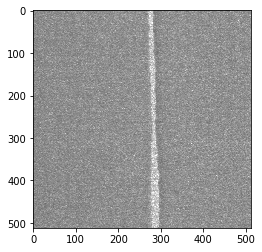

In [ ]:
#讀取一張影像，並且展示出來
img = cv2.imread(X_list[88])
plt.imshow(img)

In [ ]:
#讀取檔案，並作正規化處理
X = []
for i in tqdm(range(len(X_list))):
    img = cv2.imread(X_list[i])
#    img=(img-np.mean(img))/np.std(img)
    img=img.astype('float32')
    img[:,:,0]=img[:,:,0]/255
    img[:,:,1]=(img[:,:,1]-np.mean(img[:,:,1]))/np.std(img[:,:,1])
    img[:,:,2]=(img[:,:,2]-np.min(img[:,:,2]))/(np.max(img[:,:,2])-np.min(img[:,:,2]))
    X.append(img)

100%|██████████████████████████████████████| 2528/2528 [00:40<00:00, 62.02it/s]


In [ ]:
#切分訓練集和驗證集
seed=42
x_train, x_test, y_train, y_test = train_test_split(
    X, y_list,
    test_size = 0.2,
    random_state = seed
)


In [ ]:
#設定訓練參數和訓練模型存放路徑
batch_size = 8
num_classes = 6
epochs = 40
model_name = 'trained_model_res_'+str(seed)
save_dir = os.path.join(os.getcwd(), 'saved_models')


In [ ]:
#將label資料作one-hot encoder
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
#將訓練資料轉成ndarray
x_train=np.array(x_train)
x_test=np.array(x_test)

In [ ]:
#設定模型
model = Sequential()

model.add(resmodel)

# for layer in resmodel.layers[0:-20]:
#     layer.trainable = False    

model.add(Flatten())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 16, 16, 2048)      23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 524288)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                33554496  
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_50 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
__________

In [ ]:
# 初始化Adam optimizer
opt = keras.optimizers.Adam(lr=0.00001)

# 設定訓練方式，包含loss、optimizer..)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# 呼叫影像擴充
print('Using real-time data augmentation.')
datagen = ImageDataGenerator(
    zoom_range=0.1,
    #rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect')

# early stop存放模型設置
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

# early stop參數設定
earlystop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)

# 開始訓練
model_history = model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4,
                    callbacks=[earlystop, checkpoint])


Using real-time data augmentation.
Epoch 1/40
253/253 [==============================] - 120s 473ms/step - loss: 0.8948 - acc: 0.6775 - val_loss: 0.3380 - val_acc: 0.9209

Epoch 00001: val_loss improved from inf to 0.33802, saving model to F:\AnacondaProjects\ecyor\aoi\saved_models\trained_model_res_42


In [ ]:
#畫圖：learning curve
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.figure(figsize=(18, 7))
plt.subplot(121)
plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')

plt.subplot(122)
plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.legend(loc='upper left')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
#plt.legend(loc='best')

plt.show()

In [ ]:
#對test進行預測，讀入之前存到的模型
model = load_model('saved_models\\'+'trained_model_res_'+str(seed))

In [ ]:
#讀取test的檔案列表
pd_test = pd.read_csv('test.csv')
X_list='test_images\\'+pd_test['ID'].values

In [ ]:
#因記憶體不夠大，改成一筆一筆讀取並作預測
X = []
for i in tqdm(range(len(X_list))):
    #讀取與正規化
    img = cv2.imread(X_list[i])
    img=img.astype('float32')
    img[:,:,0]=img[:,:,0]/255
    img[:,:,1]=(img[:,:,1]-np.mean(img[:,:,1]))/np.std(img[:,:,1])
    img[:,:,2]=(img[:,:,2]-np.min(img[:,:,2]))/(np.max(img[:,:,2])-np.min(img[:,:,2]))
    #轉ndarray，之後丟給model作預測
    dat = np.reshape(img,(1,512,512,3))
    ans_r=model.predict(dat)
    X.append(ans_r)

In [ ]:
#將機率值轉成答案
pred=[]
for i in range(len(X)):
    pred.append(np.argmax(X[i]))

In [ ]:
#輸出答案
results=pd_test
results['Label']=pred
results.to_csv("results.csv",index=False)